<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint


import itertools

c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [3]:
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, nhead=4, num_layers=2):
        super().__init__(observation_space, features_dim=d_model)
        self.seq_len = observation_space.shape[0]
        self.d_model = d_model

        self.linear_embed = nn.Linear(1, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, self.seq_len, d_model) * 0.01)  # small init

        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True,
            activation="relu",
            norm_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, obs):
        # Step 1: Clean raw observation
        obs = torch.nan_to_num(obs, nan=0.0, posinf=1e6, neginf=-1e6)

        # Step 2: Normalize per sequence (per batch)
        obs = (obs - obs.mean(dim=1, keepdim=True)) / (obs.std(dim=1, keepdim=True) + 1e-8)

        # Step 3: Transformer pipeline
        x = obs.unsqueeze(-1)                               # [B, S] -> [B, S, 1]
        x = self.linear_embed(x)                            # [B, S, D]
        x = x + self.positional_encoding[:, :x.size(1), :]  # Add PE
        x = self.transformer(x)                             # [B, S, D]
        x = self.layer_norm(x)                              # Normalize
        x = x.mean(dim=1)                                   # Pooling [B, D]
        return x


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [5]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-06-01'

In [7]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TRADE_END_DATE,
                    ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
# yfp = YahooFinanceProcessor()
# df = yfp.scrap_data(['AXP', 'AMGN', 'AAPL'], '2010-01-01', '2010-02-01')
print(df)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (94301, 8)
Price        date       close        high         low        open     volume  \
0      2009-01-02    2.727417    2.736134    2.559415    2.581054  746015200   
1      2009-01-02   40.791451   40.853685   39.933992   40.514850    6547900   
2      2009-01-02   14.891693   15.038068   14.175228   14.306194   10955700   
3      2009-01-02   33.941090   34.173615   32.088393   32.103395    7010200   
4      2009-01-02   30.233936   30.279052   28.816015   28.944917    7117200   
...           ...         ...         ...         ...         ...        ...   
94296  2021-10-28  429.862579  432.184418  427.106553  427.559607    1672600   
94297  2021-10-28  204.013351  213.881524  203.206396  213.162067   23199400   
94298  2021-10-28   41.607990   41.883803   41.466145   41.568589   18374700   
94299  2021-10-28   38.449150   38.653233   38.089966   38.432826    4843900   
94300  2021-10-28   46.984173   47.151917   46.749965   46.949358   12598500   

Price  

In [8]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [9]:
df.shape

(94301, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2009-01-02,2.727417,2.736134,2.559415,2.581054,746015200,AAPL,4
1,2009-01-02,40.791451,40.853685,39.933992,40.514850,6547900,AMGN,4
2,2009-01-02,14.891693,15.038068,14.175228,14.306194,10955700,AXP,4
3,2009-01-02,33.941090,34.173615,32.088393,32.103395,7010200,BA,4
4,2009-01-02,30.233936,30.279052,28.816015,28.944917,7117200,CAT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3228, 8)
Successfully added vix
Successfully added turbulence index


In [12]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [13]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,2.727417,2.736134,2.559415,2.581054,746015200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,2.727417,2.727417,39.189999,0.0
1,2009-01-02,AMGN,40.791451,40.853685,39.933992,40.514850,6547900.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,40.791451,40.791451,39.189999,0.0
2,2009-01-02,AXP,14.891693,15.038068,14.175228,14.306194,10955700.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,14.891693,14.891693,39.189999,0.0
3,2009-01-02,BA,33.941090,34.173615,32.088393,32.103395,7010200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,33.941090,33.941090,39.189999,0.0
4,2009-01-02,CAT,30.233936,30.279052,28.816015,28.944917,7117200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,30.233936,30.233936,39.189999,0.0
5,2009-01-02,CRM,8.431123,8.475732,7.843769,7.955292,4069200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,8.431123,8.431123,39.189999,0.0
6,2009-01-02,CSCO,11.099333,11.125511,10.634680,10.739390,40980600.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,11.099333,11.099333,39.189999,0.0
7,2009-01-02,CVX,39.716721,40.121573,38.190754,38.528129,13695900.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,39.716721,39.716721,39.189999,0.0
8,2009-01-02,DIS,20.259750,20.352919,19.057039,19.277254,9796600.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,20.259750,20.259750,39.189999,0.0
9,2009-01-02,GS,65.354599,66.002421,61.912108,63.290607,14088500.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,65.354599,65.354599,39.189999,0.0


In [14]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [15]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

83897
9715


In [16]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,273.307526,274.697460,266.552435,267.395665,2932900.0,1.0,-0.018501,288.644682,257.612908,52.413036,-20.026804,0.598862,273.539193,266.872868,30.43,12.918632
2892,2020-06-30,V,186.425064,186.984814,183.520170,184.803732,9040100.0,1.0,1.025072,194.257232,180.858008,53.021017,-51.428970,2.103724,187.155981,177.570353,30.43,12.918632
2892,2020-06-30,VZ,40.665901,40.783923,40.097921,40.510995,17414800.0,1.0,-0.352851,43.524875,39.336046,48.097046,-50.671315,8.321291,41.178803,41.544123,30.43,12.918632
2892,2020-06-30,WBA,32.880199,33.027577,32.391533,32.670771,4782100.0,1.0,-0.070741,35.890249,30.733455,48.830187,-14.266622,0.948752,32.963969,32.795456,30.43,12.918632
2892,2020-06-30,WMT,37.177685,37.286317,36.792809,37.003872,20509200.0,1.0,-0.283846,38.250865,36.341645,48.159659,-69.838905,3.557607,37.711030,38.330749,30.43,12.918632


In [17]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,88.485016,89.274822,88.436417,88.730466,110737200.0,2.0,2.967005,91.235601,78.913914,62.807188,107.472280,29.811448,82.608455,76.490383,28.620001,53.068269
0,2020-07-01,AMGN,218.336411,219.286383,199.046267,201.562376,6575800.0,2.0,3.306031,211.284535,182.023969,61.279637,272.795129,47.010072,195.339146,196.314670,28.620001,53.068269
0,2020-07-01,AXP,88.271126,91.002318,87.886315,89.397389,3301000.0,2.0,-0.373038,105.848934,84.123358,48.504817,-62.638297,1.752099,93.215670,86.937895,28.620001,53.068269
0,2020-07-01,BA,180.320007,190.610001,180.039993,185.880005,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.936440,176.472335,155.614168,28.620001,53.068269
0,2020-07-01,CAT,113.409096,116.413903,113.247160,116.395920,2807800.0,2.0,1.196233,122.783119,106.548715,52.865409,35.366092,14.542117,112.244676,106.824648,28.620001,53.068269


In [18]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [19]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [20]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [21]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train = DummyVecEnv([lambda: e_train_gym])

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [22]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 3: PPO

In [23]:

from stable_baselines3.common.vec_env import DummyVecEnv

policy_kwargs = dict(
    features_extractor_class=TransformerFeatureExtractor,
    features_extractor_kwargs=dict(
        d_model=32,     # ✅ Smaller embedding
        nhead=2,        # ✅ Fewer attention heads
        num_layers=1    # ✅ Only 1 transformer block
    ),
    net_arch=dict(pi=[64, 64], vf=[64, 64])
)

model = PPO(
    policy="MlpPolicy",
    env=env_train,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log="./tensorboard/ppo_transformer/",
    learning_rate=3e-4,
    device="cuda",
    n_steps=512,        # ✅ Reduced rollout length (default is 2048)
    batch_size=64,      # ✅ Reasonable batch size
    max_grad_norm=0.5   # ✅ Gradient clipping for stability
)

import torch
torch.cuda.empty_cache()

Using cuda device


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
trained_ppo = model.learn(total_timesteps=200000)
model.save("ppo_transformer_trader")

Logging to ./tensorboard/ppo_transformer/PPO_5
----------------------------
| time/              |     |
|    fps             | 54  |
|    iterations      | 1   |
|    time_elapsed    | 9   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 2           |
|    time_elapsed         | 20          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.017092783 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00633    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.92        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0242     |
|    std                  | 1           |
|    value_loss           | 3.91    

In [45]:
trained_model = trained_ppo

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [47]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [48]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [49]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [50]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567957
std        43.790793
min         0.000000
25%        14.962670
50%        24.124061
75%        39.162682
max       652.505172
Name: turbulence, dtype: float64

In [51]:
insample_risk_indicator.turbulence.quantile(0.996)

276.4522083965639

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 55,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [54]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,88.485016,89.274822,88.436417,88.730466,110737200.0,2.0,2.967005,91.235601,78.913914,62.807188,107.472280,29.811448,82.608455,76.490383,28.620001,53.068269
0,2020-07-01,AMGN,218.336411,219.286383,199.046267,201.562376,6575800.0,2.0,3.306031,211.284535,182.023969,61.279637,272.795129,47.010072,195.339146,196.314670,28.620001,53.068269
0,2020-07-01,AXP,88.271126,91.002318,87.886315,89.397389,3301000.0,2.0,-0.373038,105.848934,84.123358,48.504817,-62.638297,1.752099,93.215670,86.937895,28.620001,53.068269
0,2020-07-01,BA,180.320007,190.610001,180.039993,185.880005,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.936440,176.472335,155.614168,28.620001,53.068269
0,2020-07-01,CAT,113.409096,116.413903,113.247160,116.395920,2807800.0,2.0,1.196233,122.783119,106.548715,52.865409,35.366092,14.542117,112.244676,106.824648,28.620001,53.068269


In [55]:
# Reset the environment
obs = e_trade_gym.reset()
if isinstance(obs, tuple):  # Gymnasium compatibility
    obs = obs[0]

done = False
account_memory = []
actions_memory = []

while not done:
    action, _states = trained_model.predict(obs, deterministic=True)

    obs, reward, done, truncated, info = e_trade_gym.step(action)

    # Save current account value and action
    account_memory.append(e_trade_gym.asset_memory[-1])
    actions_memory.append(e_trade_gym.actions_memory[-1])

# Build DataFrames
df_account_value_transformer = pd.DataFrame(account_memory, columns=["account_value"])
df_actions_transformer = pd.DataFrame(actions_memory)

# Optional: Save to disk
df_account_value_transformer.to_csv("account_value_transformer.csv", index=False)
df_actions_transformer.to_csv("actions_transformer.csv", index=False)

print("✅ Transformer-PPO trading completed.")

✅ Transformer-PPO trading completed.


<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [56]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [57]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [58]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [59]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[ 88.485, 218.336,  88.271, ...,  40.327,  31.709,  37.15 ],
       [ 88.485, 221.007,  88.534, ...,  40.415,  32.562,  37.001],
       [ 90.852, 219.303,  90.646, ...,  40.747,  33.477,  36.901],
       ...,
       [145.68 , 184.125, 173.826, ...,  41.435,  40.18 ,  47.494],
       [146.346, 185.056, 172.529, ...,  41.829,  39.437,  47.079],
       [145.886, 183.194, 169.745, ...,  41.474,  38.465,  46.693]])

In [60]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

### Use PyPortfolioOpt

In [61]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([375410.,      0.,      0.,      0.,      0.,  85810.,      0.,
            0.,      0.,      0., 205910.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  49370.,
            0.,      0.,      0., 142510., 141010.,      0.,      0.,
            0.])

In [62]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4234.615,    0.   ,    0.   ,    0.   ,    0.   ,  462.083,
          0.   ,    0.   ,    0.   ,    0.   ,  927.12 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,  253.205,    0.   ,    0.   ,    0.   ,
        521.427,  756.39 ,    0.   ,    0.   ,    0.   ])

In [63]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2020-07-01,1.001536e+06
2020-07-02,1.004131e+06
2020-07-06,1.022196e+06
2020-07-07,1.012411e+06
2020-07-08,1.027198e+06
...,...
2021-10-21,1.524364e+06
2021-10-22,1.527224e+06
2021-10-25,1.533949e+06
2021-10-26,1.537082e+06


In [64]:
print("Final account value:", df_account_value_transformer['account_value'].iloc[-1])


Final account value: 1318164.4279552174


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [65]:
# Step 1: Copy transformer PPO results
df_result_transformer = df_account_value_transformer.copy()

# Step 2: Extract unique trading dates used during rollout
unique_trade_dates = trade['date'].drop_duplicates().iloc[-len(df_result_transformer):].values

# Assign date to each row
df_result_transformer['date'] = pd.to_datetime(unique_trade_dates)
df_result_transformer.set_index('date', inplace=True)

# Rename the value column
if 'account_value' in df_result_transformer.columns:
    df_result_transformer.rename(columns={'account_value': 'transformer_ppo'}, inplace=True)

# Step 3: Prepare MVO result
MVO_result = MVO_result.copy()
MVO_result.columns = ['mean_var']
MVO_result.index = pd.to_datetime(MVO_result.index)
MVO_result.dropna(inplace=True)

# Step 4: Merge both
result = pd.merge(df_result_transformer, MVO_result, how='outer', left_index=True, right_index=True)
result.sort_index(inplace=True)

# Step 5: Save & show
result.to_csv("final_result_transformer_vs_mvo.csv")
print("✅ Final Merged Result:")
print(result.tail())


✅ Final Merged Result:
            transformer_ppo      mean_var
date                                     
2021-10-21     1.321129e+06  1.524364e+06
2021-10-22     1.332683e+06  1.527224e+06
2021-10-25     1.327589e+06  1.533949e+06
2021-10-26     1.318164e+06  1.537082e+06
2021-10-27     1.318164e+06  1.528623e+06


C:\Users\jvija\AppData\Local\Temp\ipykernel_17264\2041585653.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1500x500 with 0 Axes>

C:\Users\jvija\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


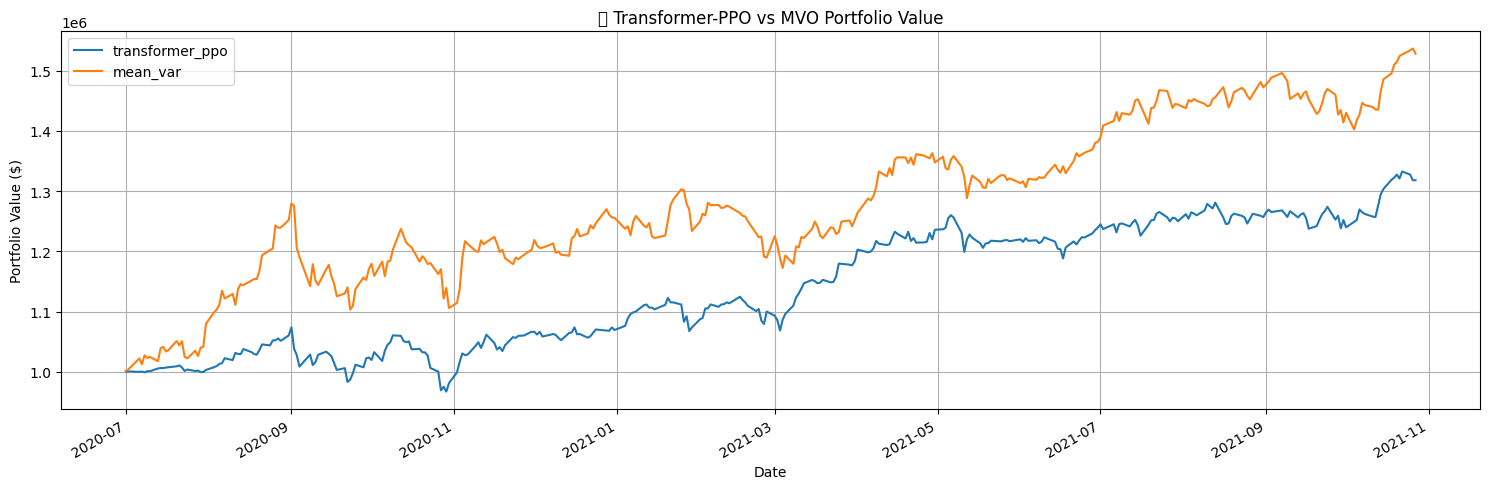

In [66]:
import matplotlib.pyplot as plt

# Ensure datetime index and no missing values in plot
plot_df = result.copy()
plot_df.dropna(subset=['transformer_ppo', 'mean_var'], how='all', inplace=True)

# Set figure size
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)

# Plot
plt.figure()
plot_df.plot(title="📈 Transformer-PPO vs MVO Portfolio Value", grid=True, ylabel="Portfolio Value ($)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()
